# Programming Project in Python

# Connect-4
## Training Setup for a Multilayer Perceptron Agent

by William Gatsinzi & Nico Kestel

In [1]:
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Plot some samples to get a first look at our data

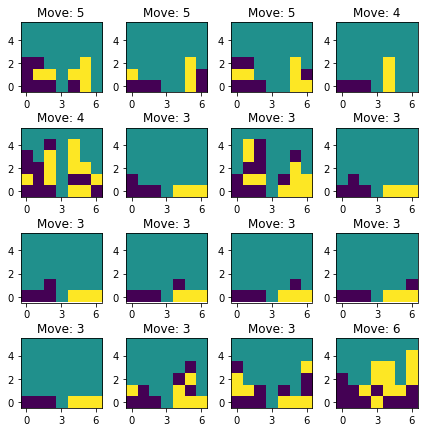

In [106]:
num_row = 4
num_col = 4
num = num_row * num_col

offset = 0

# plot boards
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,1.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X[offset+i].reshape(6, 7))
    ax.set_title('Move: {}'.format(y[offset+i]))
    ax.invert_yaxis()
    ax.set_xticks([0, 3, 6])
plt.tight_layout()

# A more detailed look
### Yellow: winner's discs
### Purple: opponent's discs

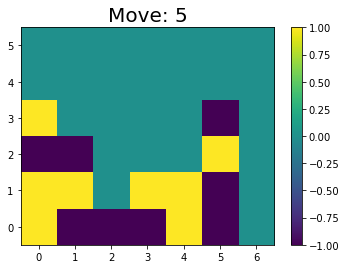

In [4]:
plt.imshow(X[35].reshape(6, 7))
plt.title('Move: {}'.format(y[35]), fontsize=20)
plt.gca().invert_yaxis()
_ = plt.colorbar()

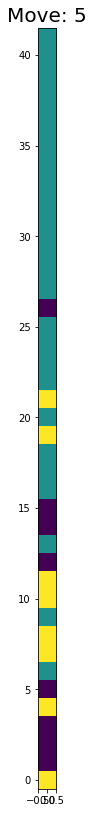

In [5]:
fig = plt.figure(figsize=(3, 14))

plt.imshow(X[35, np.newaxis].T)
plt.title('Move: {}'.format(y[35]), fontsize=20)
plt.gca().invert_yaxis()
#_ = plt.colorbar()

# How are the winner's moves distributed?
Even if our random agent has played each column with equal probability, it seems like playing columns near the center is a good idea.

[0 1 2 3 4 5 6]
[1443161 1527419 1609600 1744140 1610662 1527465 1443868]


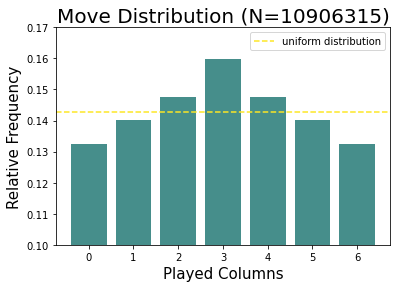

In [6]:
values, counts = np.unique(y, return_counts=True)
print(values)
print(counts)

plt.title(f'Move Distribution (N={len(y)})', fontsize=20)
plt.xlabel('Played Columns', fontsize=15)
plt.ylabel('Relative Frequency', fontsize=15)
plt.ylim((0.10, 0.17))
plt.axhline(1/7, linestyle='--', color='#FDE724', label='uniform distribution')
plt.bar(values, counts / len(y), width=.8, color='#468E8B')
_ = plt.legend()

# ---------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

# Training Setup

In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import joblib
import os.path
import matplotlib.pyplot as plt
import scipy.io
from time import time
from typing import Tuple
%matplotlib inline

### Insert flipped boards

In [107]:
def insert_flipped_boards(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Inserts flipped boards and moves to dataset.

    Parameters
    ----------
    X : np.ndarray
        Data in shape(n_samples, n_features)
    y : np.ndarray
        Labels in shape(n_samples, )

    Returns
    -------
    Extended X and y
    """

    def flip_move(move):
        return move - 2 * (move - 3)

    def flip_board(board):
        return np.flip(board.reshape(board.shape[0], 6, 7), axis=2).flatten()

    y_flipped = flip_move(y)
    X_flipped = flip_board(X).reshape(X.shape[0], 42)

    return np.concatenate((X, X_flipped), axis=0), np.concatenate((y, y_flipped), axis=0)

### Clean data

In [108]:
def clean_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Removes duplicates from X and assigns most frequent label from y.

    Parameters
    ----------
    X : np.ndarray
        Data in shape(n_samples, n_features)
    y : np.ndarray
        Labels in shape(n_samples, )

    Returns
    -------
    Cleaned X and y
    """

    # unique boards and inverse index mapping
    X_new, idx_inv = np.unique(X, axis=0, return_inverse=True)

    # init new y
    y_new = np.zeros((X_new.shape[0],), dtype=np.int8)
    n_p = int(y_new.shape[0] * 0.01)
    p_counter = 0
    p_count_total = 0
    for i in range(y_new.shape[0]):
        """p_counter += 1
        if p_counter == n_p:
            p_count_total += 1
            p_counter = 0
            print('#', end='')
            if p_count_total % 10 == 0:
                print(' ', end='')"""
        # moves corresponding to unique boards
        y_to_unique_entry = y[idx_inv == i]
        # frequency of moves
        columns, counts = np.unique(y_to_unique_entry, return_counts=True)
        # most frequent move
        y_new[i] = columns[np.argmax(counts)].astype(np.int8)

    print()
    return X_new, y_new

### Hot-One Encoding

In [4]:
def onehotencoding(X: np.ndarray) -> np.ndarray:
    return OneHotEncoder(categories=[[-1, 0, 1]] * 42).fit_transform(X).toarray().astype(np.int8)


### Split into Train and Test Set

In [109]:
def split(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    return train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [125]:
DATA = 'data/7_GROWING.mat'

data = scipy.io.loadmat(DATA)
X, y = data['data'], data['labels'][0, :]

# extract only last winning boards and moves

print(X.shape)

#X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y)

print(X.shape)

(194386, 42)
(194386, 42)


194386

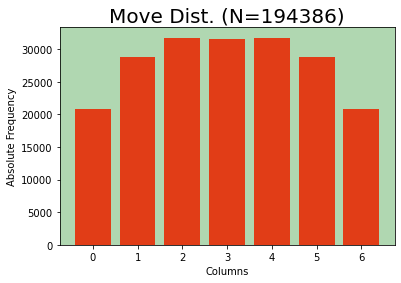

In [126]:
values, counts = np.unique(y, return_counts=True)

plt.axes().set_facecolor('#B0D7B1')
plt.title(f'Move Dist. (N={len(y)})', fontsize=20)
plt.ylabel('Absolute Frequency')
plt.xlabel('Columns')
_ = plt.bar(values, counts, color='#E13D17')

plt.savefig("MovesDist.png", bbox_inches='tight')

sum(counts)

0.010378234766048643 2000
[ 2000  2432  8211 26590 44231 46309 29247 16011  8496  4658  2296  1120
   534   302   144    74    40    16]


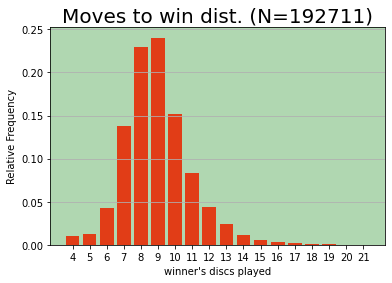

In [122]:
n_moves, c_moves = np.unique(abs(X==1).sum(axis=1) + 1, return_counts=True)
print(c_moves[0] / X.shape[0], c_moves[0])
print(c_moves)

#fig = plt.figure(figsize=(18, 8))
plt.axes().set_facecolor('#B0D7B1')
plt.title(f'Moves to win dist. (N={X.shape[0]})', fontsize=20)
plt.xlabel('winner\'s discs played')
plt.ylabel(f'Relative Frequency')
plt.bar(n_moves, c_moves / X.shape[0], color='#E13D17')
#plt.axvline(moves_per_game, color='#FDE724', linestyle='--', label=f'{moves_per_game:.2f}: avg. moves/win')
#plt.legend()
plt.grid(axis='y')
_=plt.xticks(range(4, 22))
plt.savefig("MovesToWin.png", bbox_inches='tight')

In [91]:
X = onehotencoding(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

mlp = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(126*2),
                    max_iter=1500,
                    alpha=0.001,
                    n_iter_no_change=10,
                    learning_rate='adaptive',
                    learning_rate_init=0.005,
                    shuffle=True,
                    tol=0.0001,
                    verbose=0)

params = [{'hidden_layer_sizes': [(126*3,), (126*2,)], \
           'alpha': [0.001], \
           'learning_rate_init': [0.005]}]

clf = GridSearchCV(estimator=mlp, cv=2, param_grid=params, n_jobs=-1, verbose=4, refit=True)

t0 = time()
clf.fit(X_train, y_train)
td = time()
print(f'Finished after {(td - t0)//60} minutes and {((td-t0) % 60):.1f} seconds')

print(mlp.score(X_train, y_train))
print(mlp.score(X_test, y_test))

print('Finished with grid search with best mean cross-validated score:', clf.best_score_)
print('Best params appeared to be', clf.best_params_)

Finished after 14.0 minutes and 55.2 seconds
0.8091053294350358
0.8049967443787682


In [34]:
joblib.dump(mlp, 'models/TMP.pkl')

['models/TMP_500000.pkl']